In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import os

#전체 데이터 : 20만
#학습+테스트 : 18만
#새로운 데이터 : 2만
#클러스터링 특성(5가지): size, age, fit, body type, bmi(weight_kg + height_cm)
#추천.평가: rating_5

# 출력 디렉토리 생성
os.makedirs('plots', exist_ok=True)

In [2]:
# 데이터 로드
df = pd.read_csv('../renttherunway_data.csv')
print(f"전체 데이터 크기: {df.shape}")

# 원본 rating 분포 확인
print("원본 rating 고유값:", df['rating'].unique())

전체 데이터 크기: (192544, 15)
원본 rating 고유값: [10.  8.  4.  6.  2. nan]


In [3]:
# 선택한 컬럼
selected_columns = ['user_id', 'item_id', 'fit', 'weight', 'rating', 'body type', 'height', 'size', 'age']
df = df[selected_columns]

In [4]:
# 데이터 분할: 학습+테스트(90%, 18만)와 새로운 데이터(10%, 2만)
df_train_test, new_df = train_test_split(df, test_size=0.1, random_state=42)
print(f"학습+테스트 데이터 크기: {df_train_test.shape}, 새로운 데이터 크기: {new_df.shape}")

# 학습/테스트 분할: 학습(70% of 90% ≈ 12.6만), 테스트(30% of 90% ≈ 5.4만)
train_df, test_df = train_test_split(df_train_test, test_size=0.3, random_state=42)
print(f"학습 데이터 크기: {train_df.shape}, 테스트 데이터 크기: {test_df.shape}")

학습+테스트 데이터 크기: (173289, 9), 새로운 데이터 크기: (19255, 9)
학습 데이터 크기: (121302, 9), 테스트 데이터 크기: (51987, 9)


In [5]:
# 새로운 데이터가 비어있는지 확인
if new_df.empty:
    print("오류: 새로운 데이터가 비어 있습니다. 데이터 분할을 확인하세요.")
    exit(1)

In [6]:
# 1. 단위 변환 및 전처리
def height_to_cm(height):
    if pd.isna(height):
        return np.nan
    try:
        feet, inches = height.split("'")
        inches = inches.replace('"', '').strip()
        return int(feet) * 30.48 + int(inches) * 2.54
    except:
        return np.nan

In [7]:
# 학습 데이터 전처리
train_df['height_cm'] = train_df['height'].apply(height_to_cm)
train_df['weight'] = train_df['weight'].astype(str).str.replace('lbs', '').str.strip()
train_df['weight'] = pd.to_numeric(train_df['weight'], errors='coerce')
train_df['weight_kg'] = train_df['weight'] * 0.453592

train_df['rating'] = pd.to_numeric(train_df['rating'], errors='coerce')
train_df['rating'] = train_df['rating'].replace([np.inf, -np.inf], np.nan)
rating_median = train_df['rating'].median()
train_df['rating'] = train_df['rating'].fillna(rating_median)
train_df['rating_5'] = (train_df['rating'] / 2).round().astype(int)
train_df['rating_5'] = train_df['rating_5'].clip(1, 5)

In [8]:
# 테스트 데이터 전처리
test_df['height_cm'] = test_df['height'].apply(height_to_cm)
test_df['weight'] = test_df['weight'].astype(str).str.replace('lbs', '').str.strip()
test_df['weight'] = pd.to_numeric(test_df['weight'], errors='coerce')
test_df['weight_kg'] = test_df['weight'] * 0.453592

test_df['rating'] = pd.to_numeric(test_df['rating'], errors='coerce')
test_df['rating'] = test_df['rating'].replace([np.inf, -np.inf], np.nan)
test_df['rating'] = test_df['rating'].fillna(rating_median)
test_df['rating_5'] = (test_df['rating'] / 2).round().astype(int)
test_df['rating_5'] = test_df['rating_5'].clip(1, 5)

In [9]:
# rating_5 확인
print("학습 데이터 rating_5 고유값:", train_df['rating_5'].unique())
print("테스트 데이터 rating_5 고유값:", test_df['rating_5'].unique())

학습 데이터 rating_5 고유값: [4 3 5 2 1]
테스트 데이터 rating_5 고유값: [5 4 3 2 1]


In [10]:
# # IQR 기준 계산 (train 기준)
# Q1 = train_df['age'].quantile(0.25)
# Q3 = train_df['age'].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # 학습 데이터에서 age 이상치 제거
# train_df = train_df[(train_df['age'] >= lower_bound) & (train_df['age'] <= upper_bound)]

# # 테스트 데이터도 동일한 기준으로 제거
# test_df = test_df[(test_df['age'] >= lower_bound) & (test_df['age'] <= upper_bound)]

# print(f"IQR 기준 age 이상치 제거 후 학습 데이터 수: {len(train_df)}")
# print(f"IQR 기준 age 이상치 제거 후 테스트 데이터 수: {len(test_df)}")

### 결측치 처리
- 수치형 : 평균값으로 처리
- 범주형 : 최빈값으로 처리

In [11]:
# 2. 결측치 처리
numeric_columns = ['height_cm', 'weight_kg', 'rating_5', 'age', 'size']
for col in numeric_columns:
    mean_value = train_df[col].mean()
    train_df[col] = train_df[col].replace([np.inf, -np.inf], np.nan)
    train_df[col] = train_df[col].fillna(mean_value)
    test_df[col] = test_df[col].replace([np.inf, -np.inf], np.nan)  
    test_df[col] = test_df[col].fillna(mean_value)
    print(f"{col} 열을 평균값 {mean_value:.2f}로 채웠습니다.")

categorical_columns = ['fit', 'body type']
for col in categorical_columns:
    mode_value = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode_value)
    test_df[col] = test_df[col].fillna(mode_value)
    print(f"{col} 열을 최빈값 {mode_value}로 채웠습니다.")

print("\n학습 데이터 결측치:")
print(train_df.isna().sum())
print("\n테스트 데이터 결측치:")
print(test_df.isna().sum())

height_cm 열을 평균값 165.91로 채웠습니다.
weight_kg 열을 평균값 62.36로 채웠습니다.
rating_5 열을 평균값 4.55로 채웠습니다.
age 열을 평균값 33.87로 채웠습니다.
size 열을 평균값 12.28로 채웠습니다.
fit 열을 최빈값 fit로 채웠습니다.
body type 열을 최빈값 hourglass로 채웠습니다.

학습 데이터 결측치:
user_id          0
item_id          0
fit              0
weight       18846
rating           0
body type        0
height         441
size             0
age              0
height_cm        0
weight_kg        0
rating_5         0
dtype: int64

테스트 데이터 결측치:
user_id         0
item_id         0
fit             0
weight       8088
rating          0
body type       0
height        176
size            0
age             0
height_cm       0
weight_kg       0
rating_5        0
dtype: int64


### 범주형 feature 처리

원핫 인코딩 적용

In [12]:
# 3. 원-핫 인코딩
encoder_fit = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
fit_encoded_train = encoder_fit.fit_transform(train_df[['fit']])
fit_encoded_train_df = pd.DataFrame(fit_encoded_train, columns=encoder_fit.get_feature_names_out(['fit']), index=train_df.index)
fit_encoded_test = encoder_fit.transform(test_df[['fit']])
fit_encoded_test_df = pd.DataFrame(fit_encoded_test, columns=encoder_fit.get_feature_names_out(['fit']), index=test_df.index)

encoder_body = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
body_encoded_train = encoder_body.fit_transform(train_df[['body type']])
body_encoded_train_df = pd.DataFrame(body_encoded_train, columns=encoder_body.get_feature_names_out(['body type']), index=train_df.index)
body_encoded_test = encoder_body.transform(test_df[['body type']])
body_encoded_test_df = pd.DataFrame(body_encoded_test, columns=encoder_body.get_feature_names_out(['body type']), index=test_df.index)

train_df = pd.concat([train_df, fit_encoded_train_df, body_encoded_train_df], axis=1)
test_df = pd.concat([test_df, fit_encoded_test_df, body_encoded_test_df], axis=1)

### weight_kg, height_cm 이용하여 bmi 파생변수 생성

In [13]:
# BMI 파생 변수 추가, weight,height 이용 
train_df["height_m"] = train_df["height_cm"] / 100
test_df["height_m"] = test_df["height_cm"] / 100
train_df["bmi"] = round(train_df["weight_kg"] / (train_df["height_m"] ** 2), 2)
test_df["bmi"] = round(test_df["weight_kg"] / (test_df["height_m"] ** 2), 2)

In [14]:
# 4. 스케일링
scaler_dict = {}
scaled_columns = ['size', 'age', 'bmi']  # size, age, bmi 추가(weight, height제거)
for col in scaled_columns:
    scaler = MinMaxScaler()
    train_df[f'{col}_scaled'] = scaler.fit_transform(train_df[[col]])
    test_df[f'{col}_scaled'] = scaler.transform(test_df[[col]])
    scaler_dict[col] = scaler

feature_columns = [f'{col}_scaled' for col in scaled_columns] + \
                  [col for col in train_df.columns if col.startswith(('fit_', 'body type_'))]
train_features_df = train_df[feature_columns]
test_features_df = test_df[feature_columns]

print("\n학습용 피처 컬럼:", feature_columns)


학습용 피처 컬럼: ['size_scaled', 'age_scaled', 'bmi_scaled', 'fit_fit', 'fit_large', 'fit_small', 'body type_apple', 'body type_athletic', 'body type_full bust', 'body type_hourglass', 'body type_pear', 'body type_petite', 'body type_straight & narrow']


### 원 핫 인코딩 컬럼 가중치 설정

> (원 핫 인코딩 후 생성된 컬럼 수) / (전체 컬럼 수)  
> 전체 컬럼에서 원 핫 인코딩으로 생성된 컬럼 수 만큼의 가중치를 부여하기 위해서

In [15]:
# 1. 원핫 인코딩된 컬럼들 필터링
fit_cols = [col for col in train_df.columns if col.startswith('fit_')]
body_cols = [col for col in train_df.columns if col.startswith('body type_')]

# 2. 전체 피처 컬럼 수 (스케일링된 + 인코딩된)
feature_columns = [f'{col}_scaled' for col in scaled_columns] + fit_cols + body_cols
total_feature_count = len(feature_columns)

# 3. 각 범주형 변수의 가중치 계산, 원핫컬럼으로 생성된 컬럼 수 / 전체 컬럼 수
fit_weight = len(fit_cols) / total_feature_count
body_weight = len(body_cols) / total_feature_count

# 4. 가중치 적용
train_df[fit_cols] *= fit_weight
test_df[fit_cols] *= fit_weight
train_df[body_cols] *= body_weight
test_df[body_cols] *= body_weight

#가중치 적용 한 컬럼 훈련,테스트 데이터에 적용
train_features_df = train_df[feature_columns]
test_features_df = test_df[feature_columns]

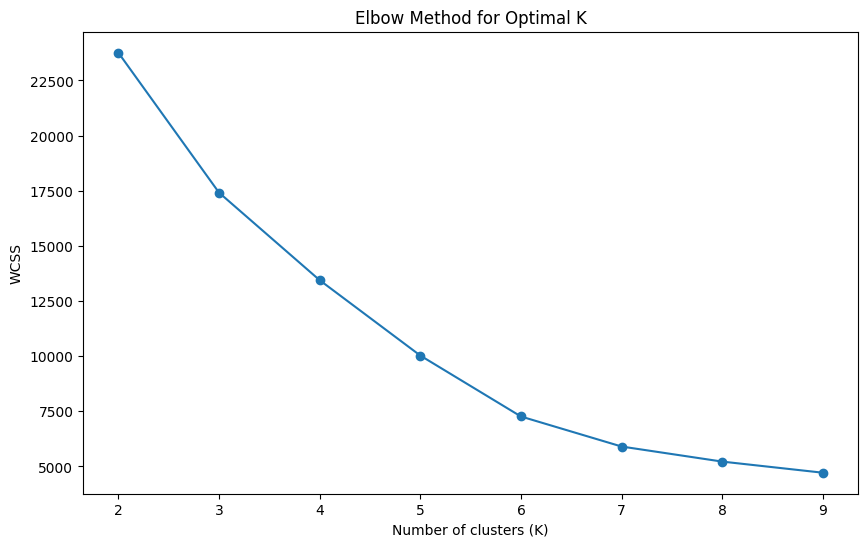

In [16]:
# 5. K-Means 클러스터링
# 엘보우 기법
wcss = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(train_features_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.savefig('plots/elbow_plot.png')
plt.show()
plt.close()

# K=7으로 설정
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
train_df['cluster'] = kmeans.fit_predict(train_features_df)
test_df['cluster'] = kmeans.predict(test_features_df)

# 실루엣 점수 계산 (학습, 테스트)
train_silhouette = silhouette_score(train_features_df, train_df['cluster'])
test_silhouette = silhouette_score(test_features_df, test_df['cluster'])

(원 핫 인코딩 된)범주형 컬럼 출력 값 = 전체 비율 * 적용한 가중치

In [17]:
# 수치형 컬럼 평균
numeric_summary = train_df.groupby('cluster')[['bmi', 'size', 'age',]].mean()

# 범주형 컬럼 (원-핫 인코딩된 컬럼들)
fit_cols = [col for col in train_df.columns if col.startswith('fit_')]
body_cols = [col for col in train_df.columns if col.startswith('body type_')]

# 범주형 컬럼 평균 (비율 의미함)
fit_summary = train_df.groupby('cluster')[fit_cols].mean()
body_summary = train_df.groupby('cluster')[body_cols].mean()

# 모두 concat
cluster_summary = pd.concat([numeric_summary, fit_summary, body_summary], axis=1)

# 보기 좋게 반올림
cluster_summary = cluster_summary.round(2)

pd.set_option('display.max_columns', None)  # 컬럼 생략 없이 보기
display(cluster_summary)

,bmi,size,age,fit_fit,fit_large,fit_small,body type_apple,body type_athletic,body type_full bust,body type_hourglass,body type_pear,body type_petite,body type_straight & narrow
cluster,,,,,,,,,,,,,
0,25.65,21.22,36.63,0.16,0.03,0.04,0.54,0.00,0.00,0.00,0.00,0.00,0.00
1,24.26,17.88,35.02,0.17,0.03,0.03,0.00,0.00,0.54,0.00,0.00,0.00,0.00
2,21.98,10.68,33.72,0.17,0.03,0.03,0.00,0.54,0.00,0.00,0.00,0.00,0.00
3,23.46,14.04,33.77,0.17,0.03,0.03,0.00,0.00,0.00,0.00,0.54,0.00,0.00
4,23.28,14.05,33.87,0.17,0.03,0.03,0.00,0.00,0.00,0.54,0.00,0.00,0.00
5,21.38,5.54,33.20,0.17,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.54,0.00
6,19.94,7.28,33.36,0.17,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.54


In [18]:
# 7. 상품 추천
cluster_items = train_df.groupby('cluster').apply(
    lambda x: x.nlargest(5, 'rating_5')[['item_id', 'rating_5']].to_dict('records')
)
print("\n군집별 상위 5개 추천 상품 (item_id, rating_5):")
for cluster, items in cluster_items.items():
    print(f"Cluster {cluster}:")
    for item in items:
        print(f"  Item ID: {item['item_id']}, Rating: {item['rating_5']}")


군집별 상위 5개 추천 상품 (item_id, rating_5):
Cluster 0:
  Item ID: 125465, Rating: 5
  Item ID: 1043198, Rating: 5
  Item ID: 1366699, Rating: 5
  Item ID: 1420770, Rating: 5
  Item ID: 2239596, Rating: 5
Cluster 1:
  Item ID: 2494898, Rating: 5
  Item ID: 2756176, Rating: 5
  Item ID: 146684, Rating: 5
  Item ID: 131117, Rating: 5
  Item ID: 2703625, Rating: 5
Cluster 2:
  Item ID: 152662, Rating: 5
  Item ID: 2396750, Rating: 5
  Item ID: 2431951, Rating: 5
  Item ID: 193179, Rating: 5
  Item ID: 919589, Rating: 5
Cluster 3:
  Item ID: 174086, Rating: 5
  Item ID: 1693615, Rating: 5
  Item ID: 1769937, Rating: 5
  Item ID: 148089, Rating: 5
  Item ID: 2958376, Rating: 5
Cluster 4:
  Item ID: 1566348, Rating: 5
  Item ID: 1420770, Rating: 5
  Item ID: 865225, Rating: 5
  Item ID: 292441, Rating: 5
  Item ID: 2606386, Rating: 5
Cluster 5:
  Item ID: 1835732, Rating: 5
  Item ID: 842449, Rating: 5
  Item ID: 2304266, Rating: 5
  Item ID: 1913010, Rating: 5
  Item ID: 125564, Rating: 5
Cluster 

C:\Users\lbw\AppData\Local\Temp\ipykernel_17980\2138032553.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_items = train_df.groupby('cluster').apply(


In [19]:
# 8. 추천 평가
# 학습 데이터 평가
precision_scores_train = []
recall_scores_train = []
K = 5
for cluster in train_df['cluster'].unique():
    train_items = set(train_df[(train_df['cluster'] == cluster) & (train_df['rating_5'] >= 4)]['item_id'])
    recommended_items = set(item['item_id'] for item in cluster_items.get(cluster, []))
    hits = len(train_items & recommended_items)
    precision = hits / K if K > 0 else 0
    recall = hits / len(train_items) if train_items else 0
    precision_scores_train.append(precision)
    recall_scores_train.append(recall)
f1_scores_train = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_scores_train, recall_scores_train)]

# 테스트 데이터 평가
precision_scores = []
recall_scores = []
for cluster in test_df['cluster'].unique():
    test_items = set(test_df[(test_df['cluster'] == cluster) & (test_df['rating_5'] >= 4)]['item_id'])
    recommended_items = set(item['item_id'] for item in cluster_items.get(cluster, []))
    hits = len(test_items & recommended_items)
    precision = hits / K if K > 0 else 0
    recall = hits / len(test_items) if test_items else 0
    precision_scores.append(precision)
    recall_scores.append(recall)
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_scores, recall_scores)]

# 고유 추천 상품 수
unique_items = set()
for cluster, items in cluster_items.items():
    unique_items.update(item['item_id'] for item in items)

# 테스트 데이터 높은 평점 비율
feedback_scores = []
for cluster in test_df['cluster'].unique():
    recommended_items = set(item['item_id'] for item in cluster_items.get(cluster, []))
    cluster_data = test_df[(test_df['cluster'] == cluster) & (test_df['item_id'].isin(recommended_items))]
    if not cluster_data.empty:
        feedback_score = (cluster_data['rating_5'] >= 4).mean()
        feedback_scores.append(feedback_score)
    else:
        feedback_scores.append(0)

# 출력 (요청된 순서)
print(f"\n학습 데이터 평균 Precision@{K}: {np.mean(precision_scores_train):.3f}")
print(f"학습 데이터 평균 Recall@{K}: {np.mean(recall_scores_train):.3f}")
print(f"학습 데이터 평균 F1 Score: {np.mean(f1_scores_train):.3f}")
print(f"테스트 데이터 평균 Precision@{K}: {np.mean(precision_scores):.3f}")
print(f"테스트 데이터 평균 Recall@{K}: {np.mean(recall_scores):.3f}")
print(f"테스트 데이터 평균 F1 Score: {np.mean(f1_scores):.3f}")
print(f"학습 데이터 실루엣 점수: {train_silhouette:.3f}")
print(f"테스트 데이터 실루엣 점수: {test_silhouette:.3f}")
print(f"총 고유 추천 상품 수: {len(unique_items)}")
print(f"테스트 데이터 추천 상품의 높은 평점 비율 (평균): {np.mean(feedback_scores):.3f}")


학습 데이터 평균 Precision@5: 1.000
학습 데이터 평균 Recall@5: 0.002
학습 데이터 평균 F1 Score: 0.003
테스트 데이터 평균 Precision@5: 0.857
테스트 데이터 평균 Recall@5: 0.002
테스트 데이터 평균 F1 Score: 0.004
학습 데이터 실루엣 점수: 0.665
테스트 데이터 실루엣 점수: 0.667
총 고유 추천 상품 수: 34
테스트 데이터 추천 상품의 높은 평점 비율 (평균): 0.918


C:\Users\lbw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\lbw\AppData\Local\Temp\ipykernel_17980\2631143300.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


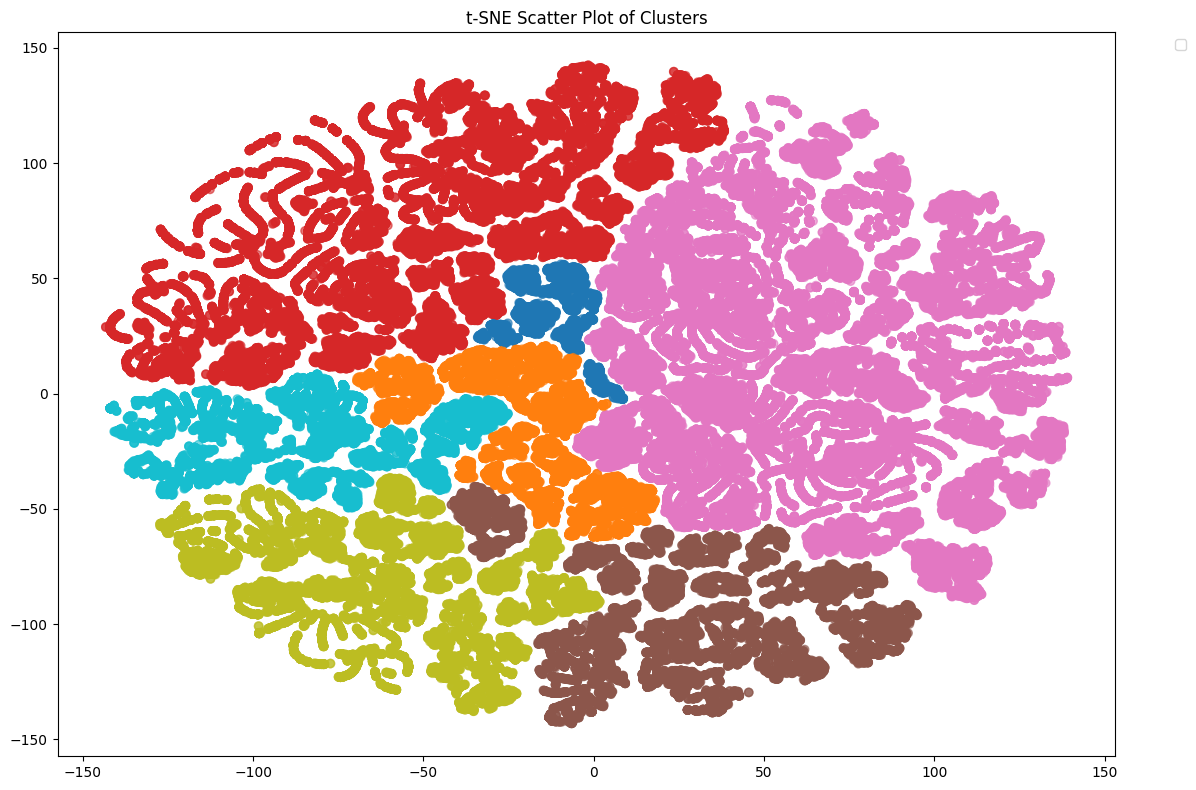

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. t-SNE로 차원 축소
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(train_features_df)

# 2. 데이터프레임 생성
tsne_df = pd.DataFrame(X_tsne, columns=["t-SNE component 1", "t-SNE component 2"])
tsne_df["Cluster"] = train_df["cluster"]

# 3. 시각화
plt.figure(figsize=(12, 8))
# sns.scatterplot(data=tsne_df, x="t-SNE component 1", y="t-SNE component 2",
#                 hue="Cluster", palette="tab20", s=10, alpha=0.8)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_df['cluster'], cmap='tab10', alpha=0.6)
plt.title("t-SNE Scatter Plot of Clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("plots/tsne_cluster_visualization.png")
plt.show()


In [21]:
# 9. 새로운 데이터 처리
print(f"\n새로운 데이터 크기: {new_df.shape}")

# 새로운 데이터 전처리
new_df['height_cm'] = new_df['height'].apply(height_to_cm)
new_df['weight'] = new_df['weight'].astype(str).str.replace('lbs', '').str.strip()
new_df['weight'] = pd.to_numeric(new_df['weight'], errors='coerce')
new_df['weight_kg'] = new_df['weight'] * 0.453592
new_df['rating'] = pd.to_numeric(new_df['rating'], errors='coerce')
new_df['rating'] = new_df['rating'].replace([np.inf, -np.inf], np.nan)
new_df['rating'] = new_df['rating'].fillna(rating_median)
new_df['rating_5'] = (new_df['rating'] / 2).round().astype(int)
new_df['rating_5'] = new_df['rating_5'].clip(1, 5)
new_df['bmi'] = new_df['weight_kg'] / ((new_df['height_cm'] / 100) ** 2)


for col in numeric_columns:
    new_df[col] = new_df[col].replace([np.inf, -np.inf], np.nan)
    new_df[col] = new_df[col].fillna(train_df[col].mean())
for col in categorical_columns:
    new_df[col] = new_df[col].fillna(train_df[col].mode()[0])

new_df['bmi'] = new_df['bmi'].replace([np.inf, -np.inf], np.nan)
new_df['bmi'] = new_df['bmi'].fillna(train_df['bmi'].mean())

fit_encoded_new = encoder_fit.transform(new_df[['fit']])
fit_encoded_new_df = pd.DataFrame(fit_encoded_new, columns=encoder_fit.get_feature_names_out(['fit']), index=new_df.index)
body_encoded_new = encoder_body.transform(new_df[['body type']])
body_encoded_new_df = pd.DataFrame(body_encoded_new, columns=encoder_body.get_feature_names_out(['body type']), index=new_df.index)
new_df = pd.concat([new_df, fit_encoded_new_df, body_encoded_new_df], axis=1)

for col in scaled_columns:
    new_df[f'{col}_scaled'] = scaler_dict[col].transform(new_df[[col]])
new_features_df = new_df[feature_columns]


새로운 데이터 크기: (19255, 9)


In [22]:
# 군집 예측
new_df['cluster'] = kmeans.predict(new_features_df)
print("\n새로운 데이터 군집 분포:")
print(new_df['cluster'].value_counts())


새로운 데이터 군집 분포:
cluster
4    6970
2    4356
5    2236
3    2177
1    1527
6    1487
0     502
Name: count, dtype: int64


In [23]:
# 새로운 데이터 실루엣 점수
new_silhouette = silhouette_score(new_features_df, new_df['cluster'])

In [24]:
# 새로운 데이터 평가
precision_scores_new = []
recall_scores_new = []
K = 5
for cluster in new_df['cluster'].unique():
    test_items = set(new_df[(new_df['cluster'] == cluster) & (new_df['rating_5'] >= 4)]['item_id'])
    recommended_items = set(item['item_id'] for item in cluster_items.get(cluster, []))
    hits = len(test_items & recommended_items)
    precision = hits / K if K > 0 else 0
    recall = hits / len(test_items) if test_items else 0
    precision_scores_new.append(precision)
    recall_scores_new.append(recall)
f1_scores_new = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_scores_new, recall_scores_new)]

# 새로운 데이터 높은 평점 비율
feedback_scores_new = []
for cluster in new_df['cluster'].unique():
    recommended_items = set(item['item_id'] for item in cluster_items.get(cluster, []))
    cluster_data = new_df[(new_df['cluster'] == cluster) & (new_df['item_id'].isin(recommended_items))]
    if not cluster_data.empty:
        feedback_score = (cluster_data['rating_5'] >= 4).mean()
        feedback_scores_new.append(feedback_score)
    else:
        feedback_scores_new.append(0)


In [25]:
# 새로운 데이터 출력
print(f"\n새로운 데이터 평균 Precision@{K}: {np.mean(precision_scores_new):.3f}")
print(f"새로운 데이터 평균 Recall@{K}: {np.mean(recall_scores_new):.3f}")
print(f"새로운 데이터 평균 F1 Score: {np.mean(f1_scores_new):.3f}")
print(f"새로운 데이터 실루엣 점수: {new_silhouette:.3f}")
print(f"새로운 데이터 추천 상품의 높은 평점 비율 (평균): {np.mean(feedback_scores_new):.3f}")



새로운 데이터 평균 Precision@5: 0.600
새로운 데이터 평균 Recall@5: 0.003
새로운 데이터 평균 F1 Score: 0.005
새로운 데이터 실루엣 점수: 0.584
새로운 데이터 추천 상품의 높은 평점 비율 (평균): 0.904


In [26]:
# 추천 상품 출력
print("\n새로운 데이터에 대한 군집별 추천 상품:")
for cluster in new_df['cluster'].unique():
    print(f"Cluster {cluster} 추천 상품:")
    for item in cluster_items.get(cluster, []):
        print(f"  Item ID: {item['item_id']}, Rating: {item['rating_5']}")



새로운 데이터에 대한 군집별 추천 상품:
Cluster 6 추천 상품:
  Item ID: 823534, Rating: 5
  Item ID: 880935, Rating: 5
  Item ID: 181453, Rating: 5
  Item ID: 401533, Rating: 5
  Item ID: 148690, Rating: 5
Cluster 4 추천 상품:
  Item ID: 1566348, Rating: 5
  Item ID: 1420770, Rating: 5
  Item ID: 865225, Rating: 5
  Item ID: 292441, Rating: 5
  Item ID: 2606386, Rating: 5
Cluster 1 추천 상품:
  Item ID: 2494898, Rating: 5
  Item ID: 2756176, Rating: 5
  Item ID: 146684, Rating: 5
  Item ID: 131117, Rating: 5
  Item ID: 2703625, Rating: 5
Cluster 2 추천 상품:
  Item ID: 152662, Rating: 5
  Item ID: 2396750, Rating: 5
  Item ID: 2431951, Rating: 5
  Item ID: 193179, Rating: 5
  Item ID: 919589, Rating: 5
Cluster 5 추천 상품:
  Item ID: 1835732, Rating: 5
  Item ID: 842449, Rating: 5
  Item ID: 2304266, Rating: 5
  Item ID: 1913010, Rating: 5
  Item ID: 125564, Rating: 5
Cluster 3 추천 상품:
  Item ID: 174086, Rating: 5
  Item ID: 1693615, Rating: 5
  Item ID: 1769937, Rating: 5
  Item ID: 148089, Rating: 5
  Item ID: 2958376, 